In [3]:
# Dependencies
import pandas as pd
from scipy.io import loadmat
import glob
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras import layers
from keras import activations
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf


## Step 1: Load the data.
Class has 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

In [6]:
# folder names
dc_folders = ['Europe', 'Japan', 'USA', 'Upsample']

# Implement the dataset class
class DrivingCyclesDataset(Dataset):
    def __init__(self,
                 path_to_dc,
                 train=True):
        # path_to_dc: where you put the driving cycles dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # train: return training set or test set
        
        # Load all the driving cycles
        alldata = []
        dcnames = []
        if (train == True):
            mat = loadmat('./DrivingCycles/WLTPextended.mat')
            df = pd.DataFrame(mat['V_z'], columns = ['V_z']) # velocity 
            df2 = pd.DataFrame(mat['T_z'], columns = ['T_z']) # time
            df3 = pd.DataFrame(mat['D_z'], columns = ['D_z']) # acceleration
            df = pd.concat([df, df2, df3], axis=1)
            alldata.append(df)
            dcnames.append('WLTPextended.mat')
            for folder in dc_folders:
                image_path = os.path.join(path_to_dc, folder)
                files = glob.glob(image_path + '/*.mat')
                for f in files:
                    mat = loadmat(f)
                    df = pd.DataFrame(mat['V_z'], columns = ['V_z'])
                    df2 = pd.DataFrame(mat['T_z'], columns = ['T_z'])
                    df3 = pd.DataFrame(mat['D_z'], columns = ['D_z'])
                    df = pd.concat([df, df2, df3], axis=1)
                    dcnames.append(os.path.basename(f))
                    # each dataframe is a driving cycle 
                    alldata.append(df)
            # Extract the driving cycles with the specified file indexes     
            self.data = (np.array(alldata, dtype=object))[p] #numpy array of dataframes 
            self.names = (np.array(dcnames, dtype=object))[p]
        
        else:
            image_path = os.path.join(path_to_dc, 'test')
            files = glob.glob(image_path + '/*.mat')
            for f in files:
                mat = loadmat(f)
                df = pd.DataFrame(mat['V_z'], columns = ['V_z'])
                df2 = pd.DataFrame(mat['T_z'], columns = ['T_z'])
                df3 = pd.DataFrame(mat['D_z'], columns = ['D_z'])
                df = pd.concat([df, df2, df3], axis=1)
                dcnames.append(os.path.basename(f))
                # each dataframe is a driving cycle 
                alldata.append(df)

            self.data = alldata
            self.names = dcnames


    def __len__(self, idx):
        # Return the number of samples in a driving cycle 
        return (self.data[idx]).size
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the driving cycle and its name 
        return self.data[idx]

In [7]:
def split_train_test(lendata, percentage=0.8):
    idxs_train = int(percentage * lendata)
    idxs_test = idxs_train + 1 
    return idxs_train, idxs_test

LENDATA = 36 + 6 + 4 + 1 # number of driving cycles = 47
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)
idxs_test = 22 # only 1 test driving cycle for easier visualisation
p = np.random.permutation(int(LENDATA-1))

In [12]:
def create_dataset(dataset, h, f, test):
    x = [] #append the last 50 values
    y = [] #append the future value 
    for df in dataset:
        features_considered = ['V_z', 'D_z']
        # features_considered = ['V_z']
        features = df[features_considered]
        for i in range(h, df.shape[0]-f):
            x.append(features[i-h:i])
            if (test == False):
                y.append(df['V_z'][i:i+f])
            else:
                y.append(df['V_z'][i])
    x = np.array(x) 
    y = np.array(y)  
    # x = np.asarray(x).astype(np.float32)
    return x,y

## Step 2: Explore the data. 

### Step 2.1: Data visualisation.

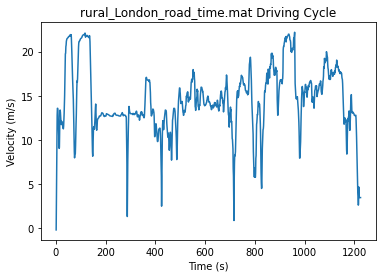

(133683, 15, 2)
(1205, 15, 2)


In [13]:
# loading datasets
dc_path = './DrivingCycles/'
dataset_train  = DrivingCyclesDataset(dc_path, train=True)
dataset_test = DrivingCyclesDataset(dc_path, train=False)

# Plot 1 sample from the test set
sample_data = dataset_test.data[0]
sample_name = dataset_test.names[0]
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# scaling the datasets 
scaler = MinMaxScaler(feature_range=(0,1))
for df in dataset_train: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    df['D_z'] = scaler.fit_transform(df[['D_z']])
for df in dataset_test: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    df['D_z'] = scaler.fit_transform(df[['D_z']])

# parameters h and f
h = 15 # length of historical sequence
f = 5 # length of forecast sequence 

# create training set and test set 
pd.options.mode.chained_assignment = None
x_train, y_train = create_dataset(dataset_train, h, f, test=False)
x_test, y_test = create_dataset(dataset_test, h, f, test=True)

# check 
print(x_train.shape)
print(x_test.shape)

# reshaping input to LSTM model 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

## Step 3: LSTM
In this section we will try to make a LSTM predictor to predict the future velocity. 

### Step 3.1: Define the model. 


In [14]:
model = Sequential([
    layers.Conv1D(filters=50,
                  kernel_size=5,
                  strides=1,
                   padding="causal",
                   activation="relu",
                   input_shape=x_train.shape[-2:]),
    layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128, return_sequences=True),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(units=f)
])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 15, 50)            550       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 50)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 32)            4832      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 13, 32)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 13, 128)           82432     
                                                                 
 lstm_3 (LSTM)               (None, 13, 128)          

### Step 3.2: Train the model.

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

# model.compile(loss = "mse", optimizer = 'adam', metrics = ['mae', 'mse'])
model.compile(loss = "mse", optimizer = 'adam')
model.fit(x_train, y_train, epochs=10, batch_size=50, callbacks=[early_stopping])
model.save('speed_prediction_cnn.h5')

# load the model 
model = load_model('speed_prediction_cnn.h5') 

### Step 3.3: Deploy the trained model onto the test set. 

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# check
print(predictions.shape)

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

#check
print(y_test_scaled.shape)

### Step 3.5: Evaluate the performance of the model 

In [18]:
results = model.evaluate(x_test, y_test, batch_size=50)
print("test loss: ", results)


25/25 [==============================] - 6s 41ms/step - loss: 0.0017
test loss:  0.0017121717100962996


### Step 3.6: Visualisation of prediction

Text(0, 0.5, 'Time (s)')

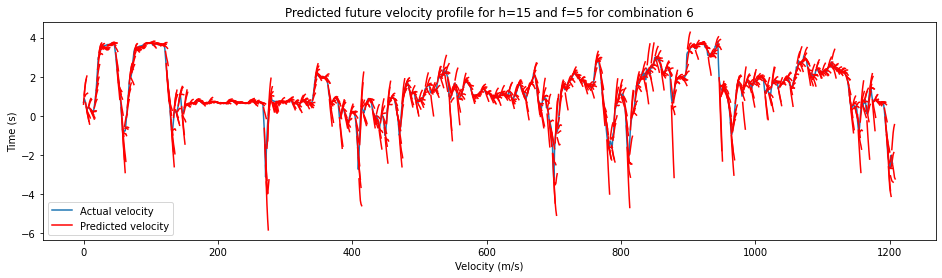

In [17]:
# Combination information
combi = 'S6'

# plotting
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(y_test_scaled)
# plt.plot(predictions, color='red') 
for i in range(predictions.shape[0]): 
    plt.plot(range(i,i+f), predictions[i], color='red') 
plt.legend(['Actual velocity', 'Predicted velocity'])
title = 'Predicted future velocity profile for h=' + str(h) + ' and f=' + str(f) + ' for combination ' + str(combi)
plt.title(title)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Time (s)")